In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import plotly.express as px
import sklearn as sk
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import Image, HTML
from datetime import datetime, timedelta
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline

customers = pd.read_csv("olist_customers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
orders_items = pd.read_csv("olist_order_items_dataset.csv")
orders_payments = pd.read_csv("olist_order_payments_dataset.csv")
orders_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
translation = pd.read_csv("product_category_name_translation.csv")

rfm = pd.read_csv("rfm.csv")

In [2]:
df = customers.merge(orders, on = 'customer_id')
df = df.merge(orders_reviews, on = 'order_id')
df = df.merge(orders_payments, on = 'order_id')
df = df.merge(orders_items, on = 'order_id')
df = df.merge(products, on = 'product_id')

In [3]:
#je remplace product_category_name par categroy_name_english
df = df.merge(translation, on ='product_category_name')

In [4]:
supprimer_carac = ["product_category_name", "product_weight_g",
                     "product_length_cm", "product_height_cm",
                     "product_width_cm"]
df= df.drop(supprimer_carac, axis=1)
df.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty',
       'product_category_name_english'],
      dtype='object')

In [5]:
df = df.rename(columns={"product_category_name_english":"product_category_name"})
df.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty',
       'product_category_name'],
      dtype='object')

In [6]:
#je convertis les colonnes avec des dates en datetime
colonnes = ['order_purchase_timestamp','shipping_limit_date','order_delivered_carrier_date',
            'order_delivered_customer_date','order_estimated_delivery_date','order_approved_at']
for i in colonnes:
    df[colonnes] = df[colonnes].apply(pd.to_datetime)

In [7]:
df.shape

(116581, 32)

In [8]:
def unique_value_count(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            print(f"{col}: {df[col].nunique()}")
            print('-'*40)
unique_value_count(df)

customer_id: 97255
----------------------------------------
customer_unique_id: 94087
----------------------------------------
customer_city: 4095
----------------------------------------
customer_state: 27
----------------------------------------
order_id: 97255
----------------------------------------
order_status: 7
----------------------------------------
review_id: 97053
----------------------------------------
review_comment_title: 4549
----------------------------------------
review_comment_message: 35909
----------------------------------------
review_creation_date: 633
----------------------------------------
review_answer_timestamp: 96897
----------------------------------------
payment_type: 4
----------------------------------------
product_id: 32328
----------------------------------------
seller_id: 3033
----------------------------------------
product_category_name: 71
----------------------------------------


In [9]:
#je supprime les lignes dont les noms de catégories de produits sont manquants
indexNan = df[df['product_category_name'].isnull()].index
df.drop(indexNan, inplace =True)

In [10]:
#je prend les commandes delivered uniquement
dt = df[df['order_status'] == 'delivered']

In [11]:
df["delai_livraison_jour"] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.round('1d').dt.days
df.drop("order_delivered_customer_date", axis=1, inplace=True) 

In [12]:
df.isnull().sum()

customer_id                           0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_id                              0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    14
order_delivered_carrier_date       1213
order_estimated_delivery_date         0
review_id                             0
review_score                          0
review_comment_title             102585
review_comment_message            66703
review_creation_date                  0
review_answer_timestamp               0
payment_sequential                    0
payment_type                          0
payment_installments                  0
payment_value                         0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0


In [13]:
dataset_acp = df.groupby('customer_unique_id').agg({
                  "freight_value": "sum",
                  "payment_sequential": "mean", 
                  "payment_installments": "mean", 
                  "review_score": "mean",
                  "delai_livraison_jour": "mean",
                  "order_item_id":"mean",
                  "freight_value": "sum",
                  })

dataset_acp = dataset_acp.rename(columns={
                            "freight_value": "Total des frais de port",
                            "nb_payment_sequential": "le nombre moyen de moyen de paiment",
                            "sum_payment_installments": "le nombre moyen de virement",
                            "review_score": "le score moyen de satisfaction",
                            "delai_livraison_jour": "le nombre moyen de delai de livraison",
                            "order_item_id":"le nombre moyen de produits",
                            })

In [14]:
dataset_acp = dataset_acp.merge(rfm, on = 'customer_unique_id')

In [15]:
dataset_acp.head()

,customer_unique_id,Total des frais de port,payment_sequential,payment_installments,le score moyen de satisfaction,le nombre moyen de delai de livraison,le nombre moyen de produits,Unnamed: 0,Recence,Frequence,Montant,Produits,r_quintiles,f_quintiles,m_quintiles,score_rfm,label
0,0000366f3b9a7992bf8c76cfdf3221e2,12.00,1.0,8.0,5.0,6.0,1.0,0,112,1,141.90,"ModeResult(mode=array(['cama_mesa_banho'], dty...",4,1,4,414,Client dépensier à garder!
1,0000b849f77a49e4a4ce2b2a4ca5be3f,8.29,1.0,1.0,4.0,3.0,1.0,1,115,1,27.19,"ModeResult(mode=array(['beleza_saude'], dtype=...",4,1,1,411,Nouveaux clients peu dépensiers
2,0000f46a3911fa3c0805444483337064,17.22,1.0,8.0,3.0,26.0,1.0,2,537,1,86.22,"ModeResult(mode=array(['papelaria'], dtype=obj...",1,1,3,113,Client dans les oublis
3,0000f6ccb0745a6a4b88665a16c9f078,17.63,1.0,4.0,4.0,20.0,1.0,3,321,1,43.62,"ModeResult(mode=array(['telefonia'], dtype=obj...",2,1,1,211,Client presque dans les oublis
4,0004aac84e0df4da2b147fca70cf8255,16.89,1.0,6.0,5.0,13.0,1.0,4,288,1,196.89,"ModeResult(mode=array(['telefonia'], dtype=obj...",2,1,4,214,Client dépensier à garder!


In [16]:
dataset_acp.drop(['customer_unique_id',"Unnamed: 0",'Produits','r_quintiles','m_quintiles','f_quintiles','score_rfm','label'],axis = 1, inplace=True)
dataset_acp.head(3)

,Total des frais de port,payment_sequential,payment_installments,le score moyen de satisfaction,le nombre moyen de delai de livraison,le nombre moyen de produits,Recence,Frequence,Montant
0,12.00,1.0,8.0,5.0,6.0,1.0,112,1,141.90
1,8.29,1.0,1.0,4.0,3.0,1.0,115,1,27.19
2,17.22,1.0,8.0,3.0,26.0,1.0,537,1,86.22


In [17]:
dataset_acp.describe()

,Total des frais de port,payment_sequential,payment_installments,le score moyen de satisfaction,le nombre moyen de delai de livraison,le nombre moyen de produits,Recence,Frequence,Montant
count,92054.00000,92054.000000,92054.000000,92054.000000,92046.000000,92054.000000,92054.000000,92054.000000,92054.000000
mean,24.82396,1.022839,2.905135,4.141094,12.521424,1.070881,237.245671,1.033111,162.632562
std,27.18121,0.184536,2.681580,1.290146,9.547146,0.267805,152.577969,0.206913,223.869604
min,0.00000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.010000
25%,14.10000,1.000000,1.000000,4.000000,7.000000,1.000000,114.000000,1.000000,61.400000
50%,17.74000,1.000000,2.000000,5.000000,10.000000,1.000000,218.000000,1.000000,105.895000
75%,26.72000,1.000000,4.000000,5.000000,16.000000,1.000000,346.000000,1.000000,180.655000
max,1794.96000,13.500000,24.000000,5.000000,210.000000,11.000000,695.000000,14.000000,13664.080000


In [18]:
dataset_acp.isnull().sum()

Total des frais de port                  0
payment_sequential                       0
payment_installments                     0
le score moyen de satisfaction           0
le nombre moyen de delai de livraison    8
le nombre moyen de produits              0
Recence                                  0
Frequence                                0
Montant                                  0
dtype: int64

In [19]:
dataset_acp.dropna(inplace=True)

In [20]:
dataset_acp.isnull().sum()

Total des frais de port                  0
payment_sequential                       0
payment_installments                     0
le score moyen de satisfaction           0
le nombre moyen de delai de livraison    0
le nombre moyen de produits              0
Recence                                  0
Frequence                                0
Montant                                  0
dtype: int64

# Méthode non supervisé : variables quatitatives

In [21]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(30,20))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 80 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 80 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='30', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)), fontsize = 25)
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)), fontsize = 25)
             
            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1), fontsize = 20)
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(10,10))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-20, 30], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-20, 30], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=True)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
    

## ACP : Analyse en composante principale

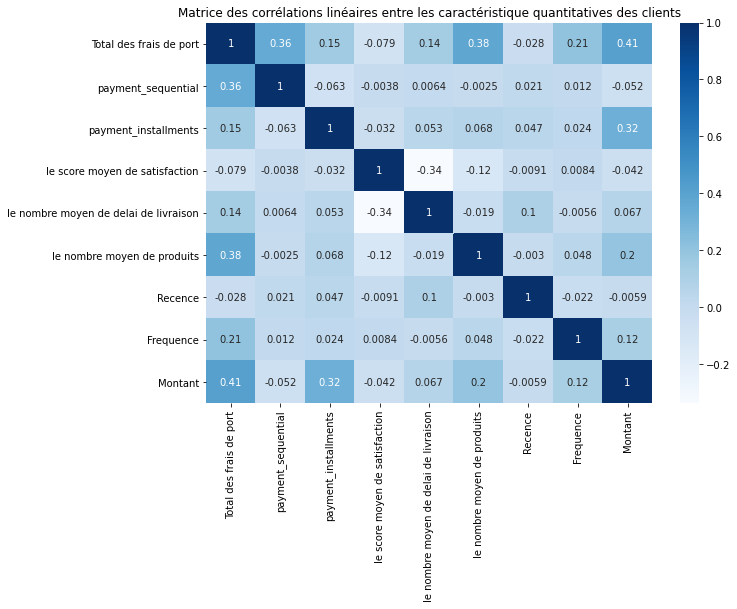

In [22]:
plt.figure(figsize = (10,7))
sns.heatmap(dataset_acp.corr(),cmap="Blues", annot = True)
plt.title("Matrice des corrélations linéaires entre les caractéristique quantitatives des clients")
plt.show()

In [23]:
from sklearn import decomposition
from sklearn import preprocessing

In [24]:
features = dataset_acp.columns
names = dataset_acp.index
sc = StandardScaler()
acp = sc.fit_transform(dataset_acp)

In [25]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='full')
pca

PCA(svd_solver='full')

In [26]:
coord = pca.fit_transform(acp)
#nombre de composantes calculées
print(pca.n_components_) 

9


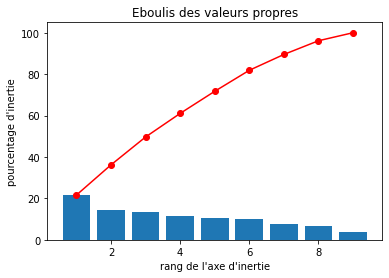

In [27]:
pca.fit(acp)
# Eboulis des valeurs propres
display_scree_plot(pca)

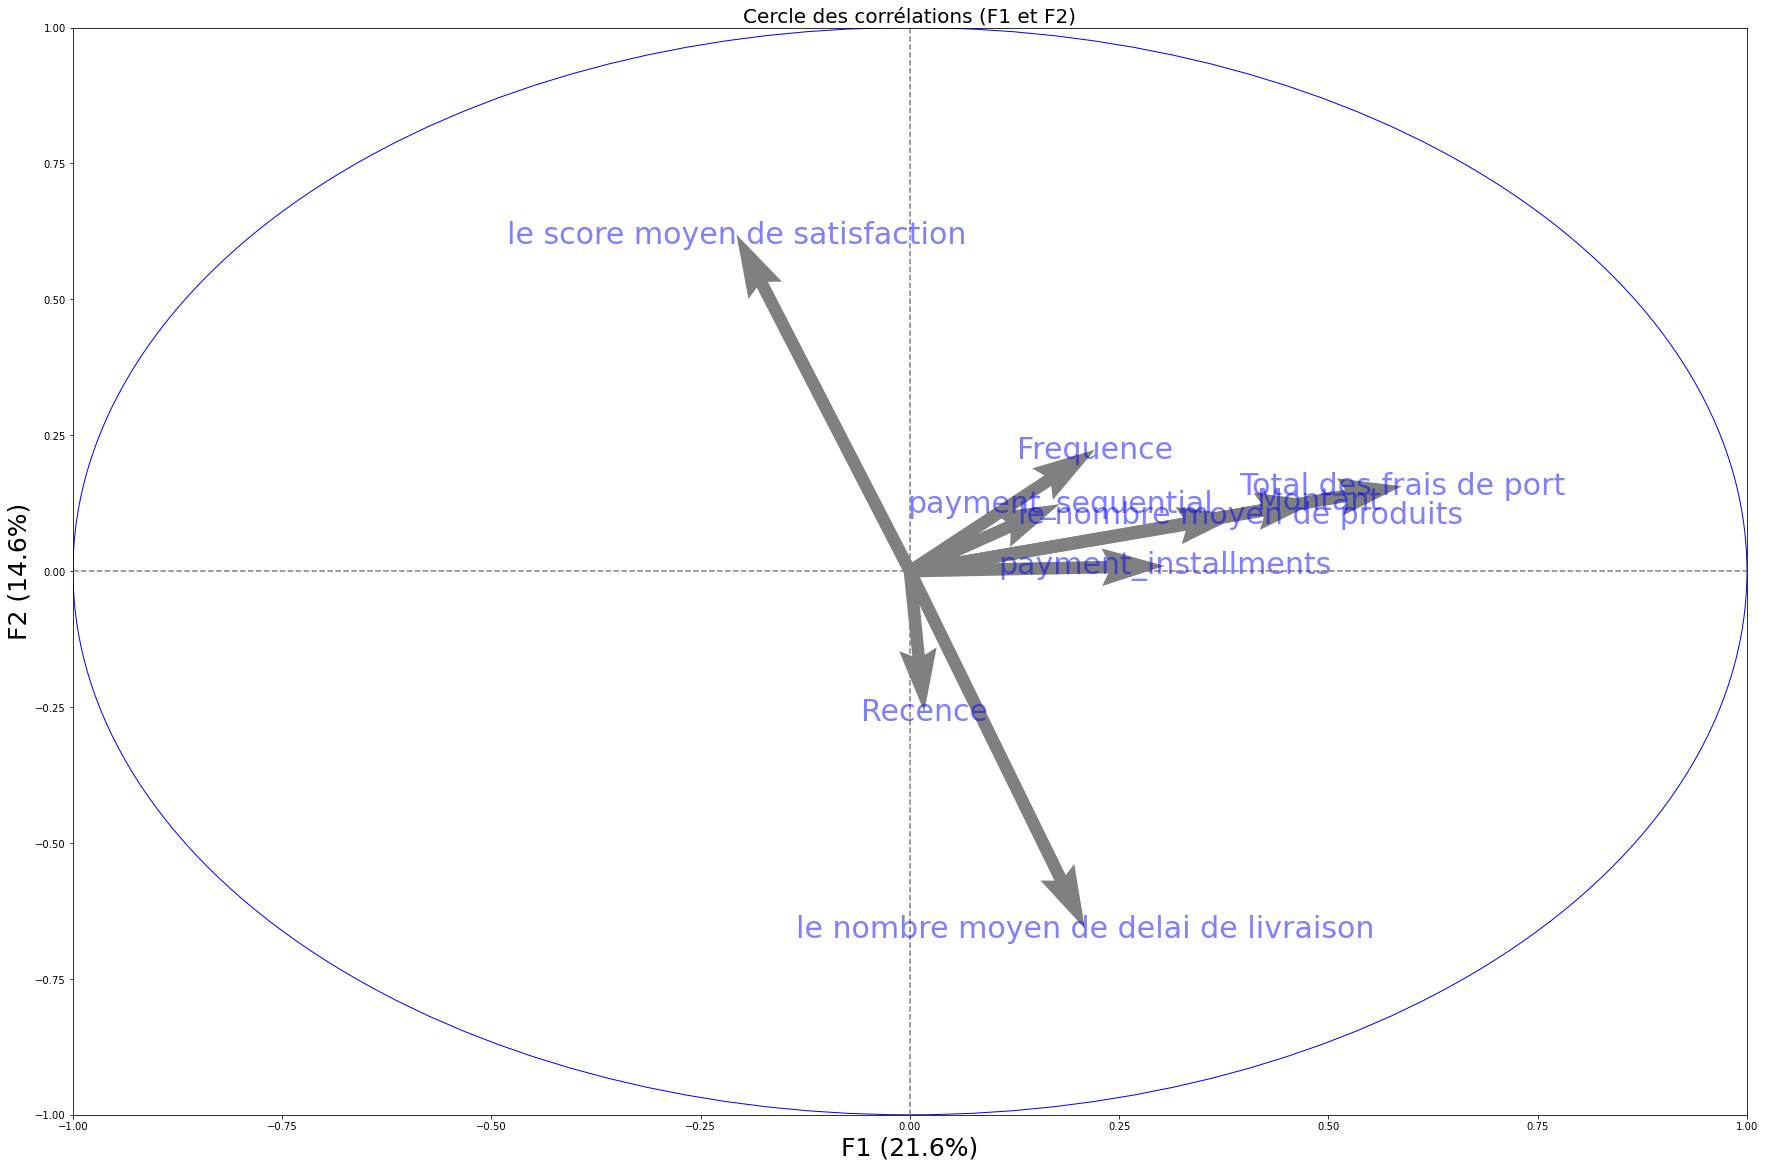

In [28]:
# Cercle des corrélations
n_comp =3
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

Deux groupes se distinguent pour moi : 
    - La fréquence des achats, le panier moyen, les frais de ports
    - La récence, la localisation, et le nombre de jours de delai de livraison
Le délai est super important pour la satisfaction client à priopri. Olist améliorer ce point si ils veulent que les clients soient plus satisfait.

In [29]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(2,3)], labels = np.array(features))

In [30]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(1,3)], labels = np.array(features))

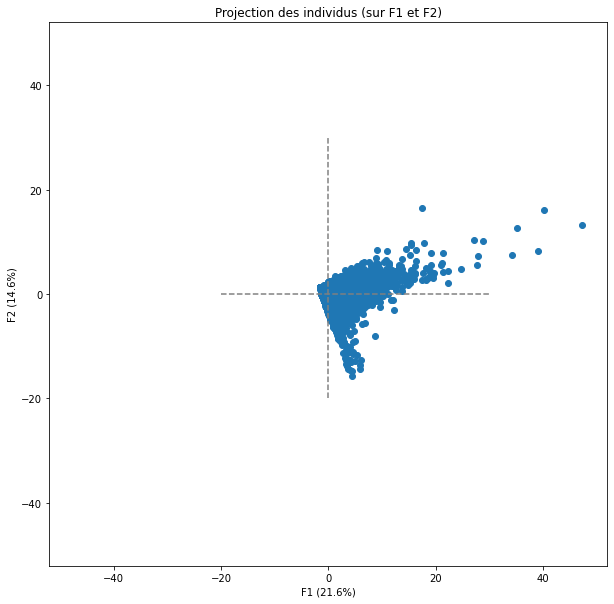

In [31]:
# Projection des individus
X_projected = pca.transform(acp)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)])

## Kmeans

Le jeu de donnée est mis à l'échelle avec MinMaxScaler

In [32]:
dataset_acp.head()

,Total des frais de port,payment_sequential,payment_installments,le score moyen de satisfaction,le nombre moyen de delai de livraison,le nombre moyen de produits,Recence,Frequence,Montant
0,12.00,1.0,8.0,5.0,6.0,1.0,112,1,141.90
1,8.29,1.0,1.0,4.0,3.0,1.0,115,1,27.19
2,17.22,1.0,8.0,3.0,26.0,1.0,537,1,86.22
3,17.63,1.0,4.0,4.0,20.0,1.0,321,1,43.62
4,16.89,1.0,6.0,5.0,13.0,1.0,288,1,196.89


In [33]:
km = dataset_acp.copy()
scaler =  MinMaxScaler()
features = km.columns
names = km.index
kme = scaler.fit_transform(km)
#pd.DataFrame(kme, columns = features, index = names)

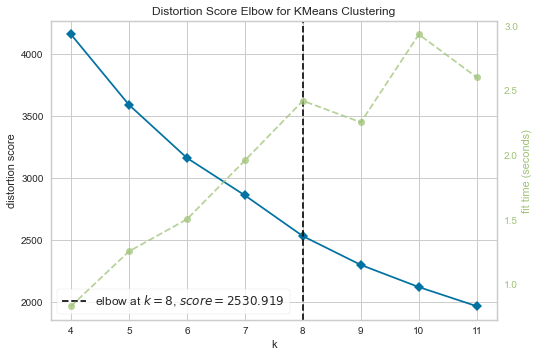

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(kme)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

La méthode du coude faite avec la librairie Yellowbrick nous suggère de choisir le 7 comme nombre de clusters. la Distorsion calcule la somme des distance au carré de chaque point assignée à son centre 

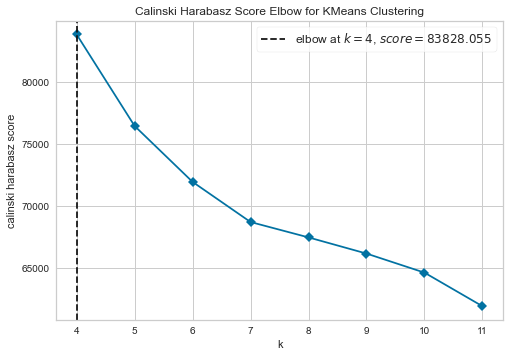

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [35]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(4,12), metric='calinski_harabasz', timings=False
)

visualizer.fit(kme)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Le score calinski_harabasz calcule le taux de dispersion entre et à l'interieur des clusters. Cette méthode nous suggère k=4

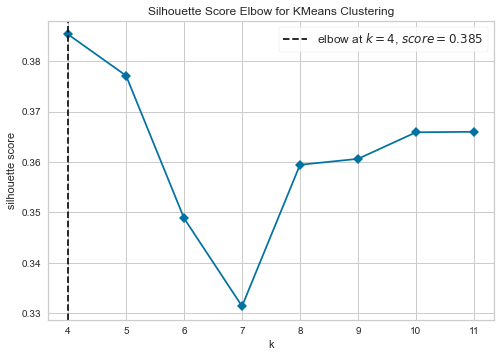

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [36]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(4,12), metric='silhouette', timings=False
)

visualizer.fit(kme)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

le score silhouette calcule la moyenne des coefficient de silhouette de chaque cluster, k=4 

On peut remarquer que les courbes sont "smooth" et donc que nos clusters ne sont pas bien différentiables.

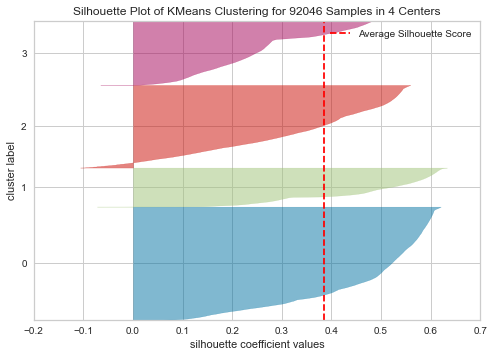

dict_keys(['ax', 'colors', 'estimator', 'is_fitted']) 


dict_keys(['ax', 'colors', 'estimator', 'is_fitted']) 




SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 92046 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=4, random_state=42))

In [37]:
from yellowbrick.cluster import silhouette_visualizer
#visualiser la silhouette des clusters
silhouette_visualizer(KMeans(4, random_state=42), kme, colors='yellowbrick')

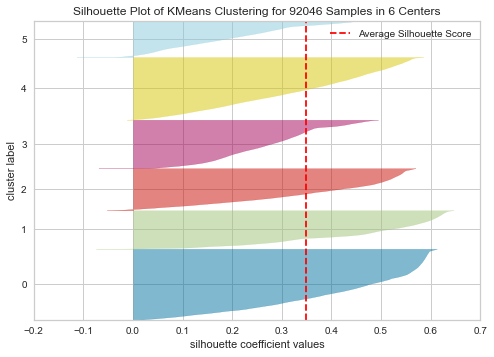

dict_keys(['ax', 'colors', 'estimator', 'is_fitted']) 


dict_keys(['ax', 'colors', 'estimator', 'is_fitted']) 




SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 92046 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=6, random_state=42))

In [38]:
from yellowbrick.cluster import silhouette_visualizer
#visualiser la silhouette des clusters
silhouette_visualizer(KMeans(6, random_state=42), kme, colors='yellowbrick')

In [39]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(kme)
y_km = kmeans.fit_predict(kme)

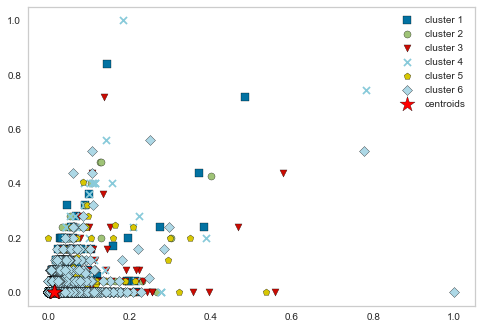

In [40]:
X = kme
# plot the 6 clusters
plt.scatter(
    X[y_km == 0, 0], X[y_km == 0, 1],
    s=50, c='b',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X[y_km == 1, 0], X[y_km == 1, 1],
    s=50, c='g',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    X[y_km == 2, 0], X[y_km == 2, 1],
    s=50, c='r',
    marker='v', edgecolor='black',
    label='cluster 3'
)
plt.scatter(
    X[y_km == 3, 0], X[y_km == 3, 1],
    s=50, c='c',
    marker='x', edgecolor='black',
    label='cluster 4'
)

plt.scatter(
    X[y_km == 4, 0], X[y_km == 4, 1],
    s=50, c='y',
    marker='p', edgecolor='black',
    label='cluster 5'
)

plt.scatter(
    X[y_km == 5, 0], X[y_km == 5, 1],
    s=50, c='lightblue',
    marker='D', edgecolor='black',
    label='cluster 6'
)

# plot the centroids
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [41]:
from sklearn import metrics
labels = kmeans.labels_
metrics.silhouette_score(kme, labels, metric='euclidean')

0.34883595048812044

In [42]:
km['cluster'] = y_km
km.head()

,Total des frais de port,payment_sequential,payment_installments,le score moyen de satisfaction,le nombre moyen de delai de livraison,le nombre moyen de produits,Recence,Frequence,Montant,cluster
0,12.00,1.0,8.0,5.0,6.0,1.0,112,1,141.90,5
1,8.29,1.0,1.0,4.0,3.0,1.0,115,1,27.19,4
2,17.22,1.0,8.0,3.0,26.0,1.0,537,1,86.22,1
3,17.63,1.0,4.0,4.0,20.0,1.0,321,1,43.62,1
4,16.89,1.0,6.0,5.0,13.0,1.0,288,1,196.89,0


## Kmeans sur jeu réduit par l'ACP

Le jeu de donnée est mis à l'échelle avec StandartScaler

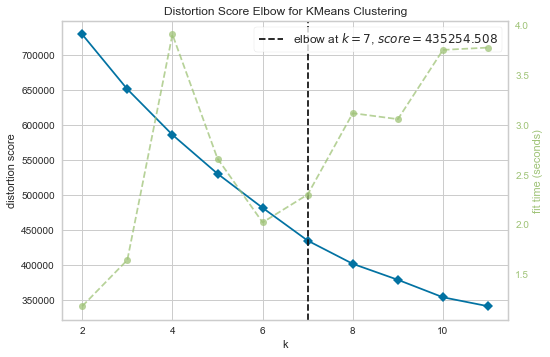

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [43]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_projected)    # Fit the data to the visualizer
visualizer.poof() 

In [44]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

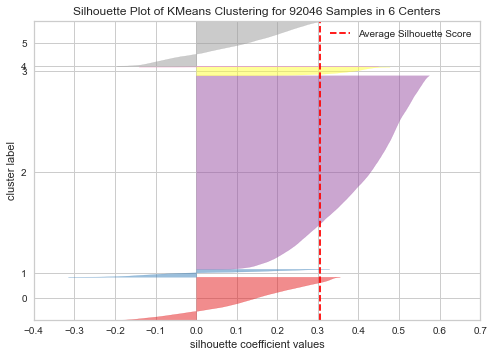

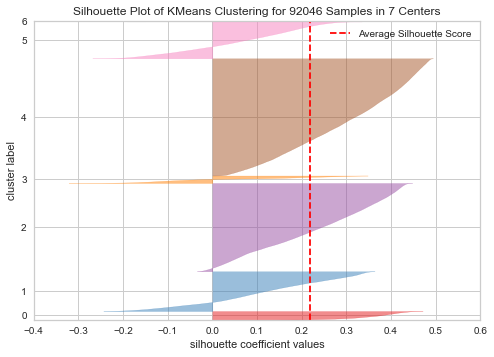

In [45]:
for i in [6,7] :
    model = KMeans(i)
    visualizer = SilhouetteVisualizer(model)
    visualizer.fit(X_projected)    # Fit the data to the visualizer
    visualizer.poof()  

In [46]:
kmeans_acp = KMeans(n_clusters=6)
kmeans_acp.fit(X_projected)
kmeans_acp=KMeans(n_clusters= 6, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
Kmeans_acp = kmeans_acp.fit_predict(X_projected)
centroids = kmeans_acp.cluster_centers_
print(centroids)

[[ 5.62321042e-01 -1.94372519e+00  2.35322830e-01 -6.51135640e-01
   3.56321803e-02 -1.56910958e-01 -4.49994863e-01  3.60535393e-01
   2.39745320e-02]
 [-2.88417654e-01 -8.39390753e-02 -1.69633629e-01  9.78461851e-01
  -5.28576293e-02  4.19790627e-01  1.87799980e-02 -1.78713668e-02
   5.12744036e-02]
 [ 6.75822301e+00  2.95492962e+00  1.42227541e+01  5.59934261e+00
  -1.76753772e+00 -5.30874632e+00 -2.48108469e+00  4.81649522e-01
  -1.77367911e+00]
 [-5.13426547e-01  5.08620078e-01  6.18840509e-02 -4.65525286e-01
  -1.25272030e-01 -3.59824082e-01  1.41731174e-01 -1.11972889e-01
  -7.68770849e-03]
 [ 2.09746362e+00  1.48638078e+00  2.59872805e-01 -6.28321152e-01
   4.40853074e+00  1.13367717e+00 -8.11306894e-01 -2.33655596e-01
  -2.44141973e-01]
 [ 3.76111681e+00  6.82353153e-01 -8.45781307e-01 -2.73173383e-01
  -1.25341833e+00  4.73745748e-01  5.09207517e-01  2.22565851e-01
  -1.46401325e-01]]


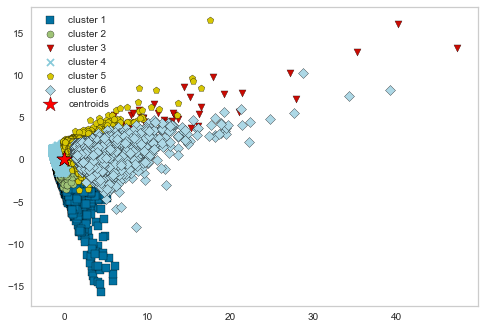

In [47]:
y_km = kmeans_acp.fit_predict(X_projected)
X = X_projected
# plot the 3 clusters
plt.scatter(
    X[y_km == 0, 0], X[y_km == 0, 1],
    s=50, c='b',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X[y_km == 1, 0], X[y_km == 1, 1],
    s=50, c='g',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    X[y_km == 2, 0], X[y_km == 2, 1],
    s=50, c='r',
    marker='v', edgecolor='black',
    label='cluster 3'
)
plt.scatter(
    X[y_km == 3, 0], X[y_km == 3, 1],
    s=50, c='c',
    marker='x', edgecolor='black',
    label='cluster 4'
)

plt.scatter(
    X[y_km == 4, 0], X[y_km == 4, 1],
    s=50, c='y',
    marker='p', edgecolor='black',
    label='cluster 5'
)

plt.scatter(
    X[y_km == 5, 0], X[y_km == 5, 1],
    s=50, c='lightblue',
    marker='D', edgecolor='black',
    label='cluster 6'
)

# plot the centroids
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [48]:
from sklearn import metrics
labels = kmeans_acp.labels_
metrics.silhouette_score(X_projected, labels, metric='euclidean')

0.20909066038303592

In [49]:
dataset_acp['cluster'] = y_km

<AxesSubplot:ylabel='cluster'>

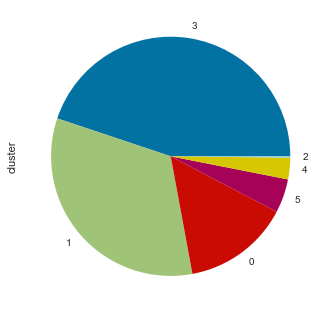

In [50]:
dataset_acp['cluster'].value_counts().plot(kind='pie')

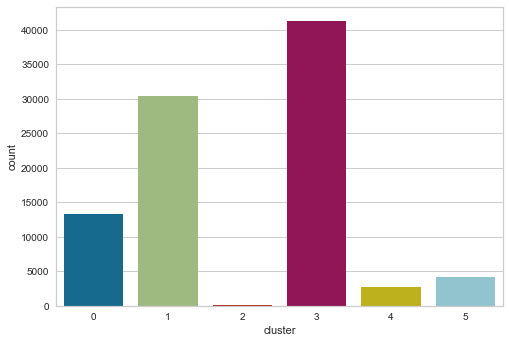

In [51]:
ax = sns.countplot(x="cluster", data=dataset_acp)

In [52]:
dataset_acp.columns

Index(['Total des frais de port', 'payment_sequential', 'payment_installments',
       'le score moyen de satisfaction',
       'le nombre moyen de delai de livraison', 'le nombre moyen de produits',
       'Recence', 'Frequence', 'Montant', 'cluster'],
      dtype='object')

In [53]:
cluster_interpretation = dataset_acp.groupby('cluster').agg({'Total des frais de port':'mean','le score moyen de satisfaction':'mean','le nombre moyen de delai de livraison':'mean','le nombre moyen de produits':'mean','Montant':'mean','Recence':'mean','Frequence':'mean','payment_installments':'mean','payment_sequential':'mean'})
cluster_interpretation.reset_index(inplace = True)
cluster_interpretation

,cluster,Total des frais de port,le score moyen de satisfaction,le nombre moyen de delai de livraison,le nombre moyen de produits,Montant,Recence,Frequence,payment_installments,payment_sequential
0,0,24.629958,1.640369,22.724827,1.077354,146.467511,233.697618,1.000000,2.962516,1.018698
1,1,20.355912,4.593925,11.732198,1.032941,136.008878,392.007561,1.000000,3.213629,1.017829
2,2,216.890427,4.079515,13.412499,1.100200,42.793841,277.969512,1.048780,1.059341,4.100328
3,3,19.922766,4.641258,9.753112,1.029784,122.086850,126.485350,1.000000,2.347840,1.015602
4,4,51.621015,4.197289,12.273000,1.113809,287.430312,219.748605,2.112681,3.277630,1.026370
5,5,81.228159,3.809837,13.347178,1.699476,728.745282,226.518175,1.011404,5.797125,1.020970


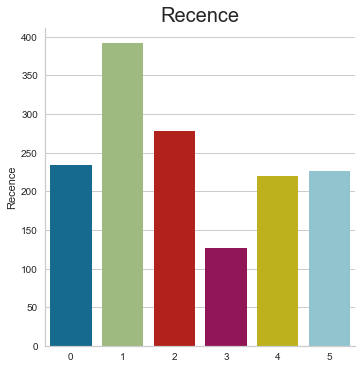

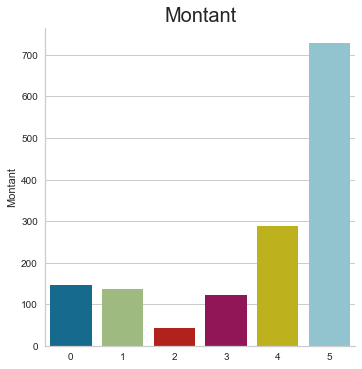

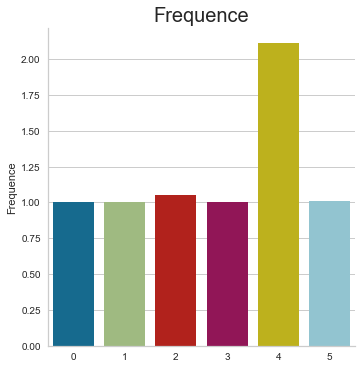

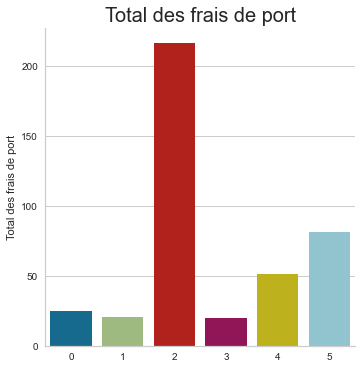

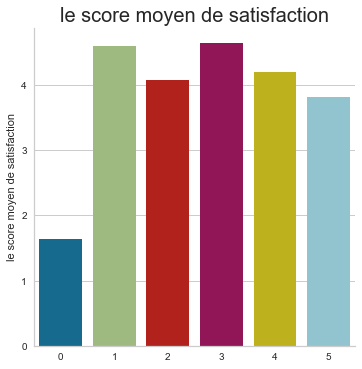

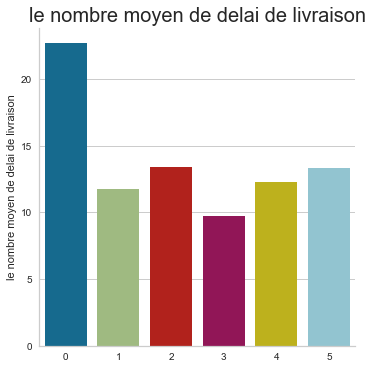

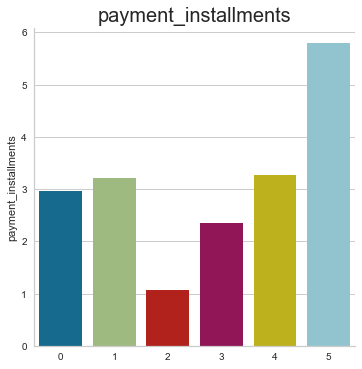

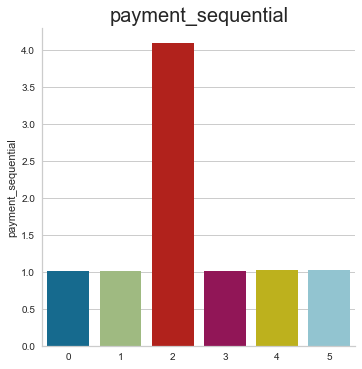

In [54]:
colonnes = ['Recence', 'Montant', 'Frequence','Total des frais de port', 'le score moyen de satisfaction','le nombre moyen de delai de livraison','payment_installments','payment_sequential']
for col in colonnes :
    g = sns.catplot(x='cluster', y=col, data= cluster_interpretation, kind="bar")
    g.set_axis_labels("", col)
    plt.title(col, fontsize = 20)
    plt.show()

- Cluster 0 : Client moyen
- Cluster 1 : Client à relancer
- Cluster 2 : Client presque dans les oublis
- Cluster 3 : Nouveaux clients
- Cluster 4 : Client fidèles
- Cluster 5 : Clients dépensiers

Comprend pourquoi certains clients ont des difficultés par rapport a la livraison de leurs commandes. Je vais pousser un peu plus loin pour faire une analyse en composante multiplus des variables catégorielle et utiliser la méthode KMODE pour voir si le délai de livraison a un lien avec la localisation du client.

# Méthode non supervisé : variable qualitative

## MCA : Analyse en composantes multiples

In [79]:
dataset_mca = df.copy()

In [80]:
# Google m'a donné les 20 plus grandes villes du Brésil !
Grande_villes = ["sao paulo","rio de janeiro","salvador","fortaleza","belo horizonte","brasilia","curitiba","manaus","recife","belem","porto alegre","goiania","guarulhos","campinas","nova iguacu","maceio","sao luis","duque de caxias","natal","teresina"]
#remplacer les villes moyennes a petite avec un nombre de clients entre 1 à 10 par "Moy|pet_ville_peu_clients"
l = dataset_mca['customer_city'].value_counts().sort_values()[:3150]
names = l.index
for i in dataset_mca['customer_city'].values.tolist():
    if i in Grande_villes:
        dataset_mca['customer_city']=dataset_mca['customer_city'].replace(i,'Grande ville')
    if (i in names):
        dataset_mca['customer_city']=dataset_mca['customer_city'].replace(i,'Moy|pet_ville_peu_clients')
    else:
        dataset_mca['customer_city']=dataset_mca['customer_city'].replace(i,'Moy|pet_ville')


In [81]:
dataset_mca['customer_city'].value_counts()

Moy|pet_ville                60828
Grande ville                 45281
Moy|pet_ville_peu_clients    10472
Name: customer_city, dtype: int64

dataset_mca.loc[df.price >= 100,'product_category_name']='Cher'
dataset_mca.loc[df.price < 100, 'product_category_name']='Pas Cher'

In [82]:
dataset_mca.loc[df['review_score'] > 3, 'review_score'] = 'Notes hautes (4,5)'
dataset_mca.loc[df['review_score'] <= 3, 'review_score'] = 'Notes basses (3,4,5)'

In [83]:
dataset_mca.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name,delai_livraison_jour
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,Moy|pet_ville,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,41.0,1141.0,1.0,office_furniture,9.0
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,Moy|pet_ville,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:18,112.99,24.90,41.0,1141.0,1.0,office_furniture,19.0
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,Moy|pet_ville,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:18,112.99,24.90,41.0,1141.0,1.0,office_furniture,19.0
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,Moy|pet_ville_peu_clients,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,...,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 22:22:56,124.99,15.62,41.0,1141.0,1.0,office_furniture,19.0
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,Moy|pet_ville,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,...,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-18 21:29:19,106.99,30.59,41.0,1141.0,1.0,office_furniture,25.0


In [84]:
dataset_mca = dataset_mca[["customer_city","payment_type","review_score"]]
dataset_mca = dataset_mca.rename(columns={
                         "customer_city":"villes",
                         "payment_type":"type de paiements",
                         "label": "label",
                         "review_score":"score"
                            })

In [85]:
import prince
mca = prince.MCA(
     n_components=3,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
 )
mca = mca.fit(dataset_mca)
#Mca_mca = mca.transform(dataset_mca)
#Mca_mca.head()

In [86]:
print(mca.eigenvalues_)
print(mca.total_inertia_)
print(mca.explained_inertia_)

[0.3511665374111572, 0.34115160722147364, 0.3360460323424318]
2.0
[0.1755832687055786, 0.17057580361073682, 0.1680230161712159]


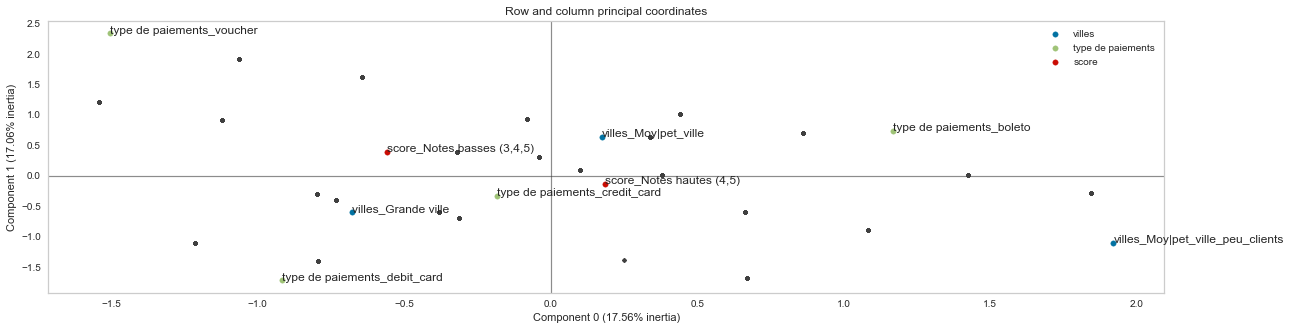

In [87]:
ax = mca.plot_coordinates(
     X=dataset_mca,
     ax=None,
     figsize=(20, 5),
     show_row_points=True,
     row_points_size=10,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=30,
     show_column_labels=True,
     legend_n_cols=1
)

Les clients des grandes villes paient avec des cartes de débit et des cartes de crédit , les clients des moyennes et petites villes paient avec des boletos. ce sont des clients qui n'ont pas de compte à la banque

Creusons un peu plus avec la méthode Kmodes qui nous permet de partitionner les clients avec des variables qualitatives

## Kmodes sur jeu de données réduits

In [88]:
Mca_mca = mca.transform(dataset_mca)

In [89]:
from kmodes.kmodes import KModes

In [90]:
cost = []
for num_clusters in list(range(1,5)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(dataset_mca)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 115407.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 89628.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 73704.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 66057.0


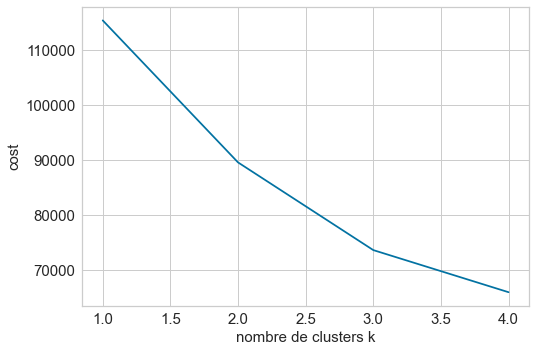

In [103]:
y = np.array([i for i in range(1,5,1)])
plt.xlabel('nombre de clusters k', fontsize = 15)
plt.ylabel('cost',fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.plot(y,cost)

Je prend K=3

In [92]:


kmode = KModes(n_clusters=3, init='Huang', n_init=5, verbose=1)

clusters = kmode.fit_predict(dataset_mca)

# Print the cluster centroids
print(kmode.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 69609.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 55377.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 14744, cost: 74928.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 13560, cost: 52767.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 78177.0
Best run was number 4
[['Moy|pet_ville' 'credit_card' 'Notes hautes (4,5)']
 ['Grande ville' 'credit_card' 'Notes hautes (4,5)']
 ['Moy|pet_ville' 'credit_card' 'Notes basses (3,4,5)']]


In [93]:
clustersDf = pd.DataFrame(clusters)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([dataset_mca, clustersDf], axis = 1).reset_index()
combinedDf = combinedDf.drop(['index'], axis = 1)

In [94]:
combinedDf.head()

,villes,type de paiements,score,cluster_predicted
0,Moy|pet_ville,credit_card,"Notes hautes (4,5)",0
1,Moy|pet_ville,credit_card,"Notes basses (3,4,5)",2
2,Moy|pet_ville,credit_card,"Notes basses (3,4,5)",2
3,Moy|pet_ville_peu_clients,credit_card,"Notes basses (3,4,5)",2
4,Moy|pet_ville,credit_card,"Notes hautes (4,5)",0


Text(0, 0.5, 'clusters')

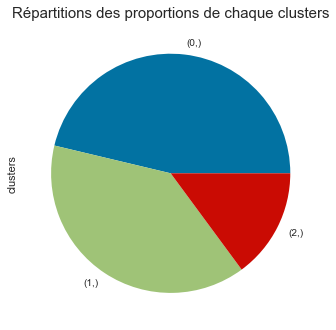

In [106]:
clustersDf.value_counts().plot(kind = "pie")
plt.title("Répartitions des proportions de chaque clusters", fontsize = 15)
plt.ylabel("clusters")

In [96]:
combinedDf.columns

Index(['villes', 'type de paiements', 'score', 'cluster_predicted'], dtype='object')

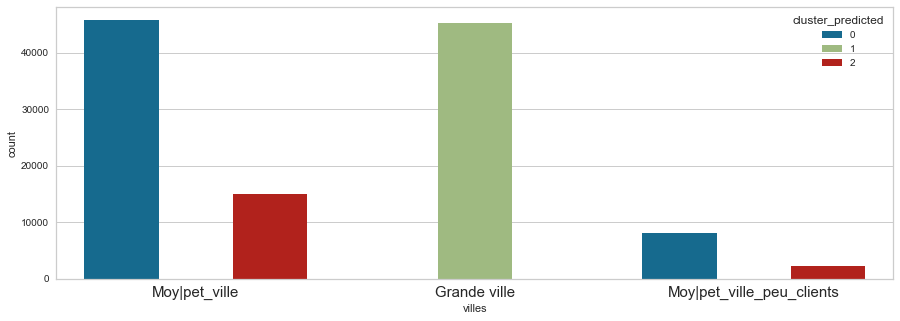

In [110]:
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['villes'],order=combinedDf['villes'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.xticks(fontsize=15)
plt.show()

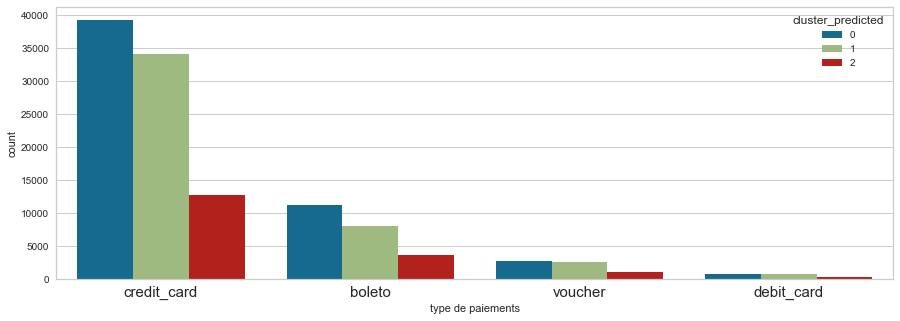

In [111]:
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['type de paiements'],order=combinedDf['type de paiements'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.xticks(fontsize=15)
plt.show()

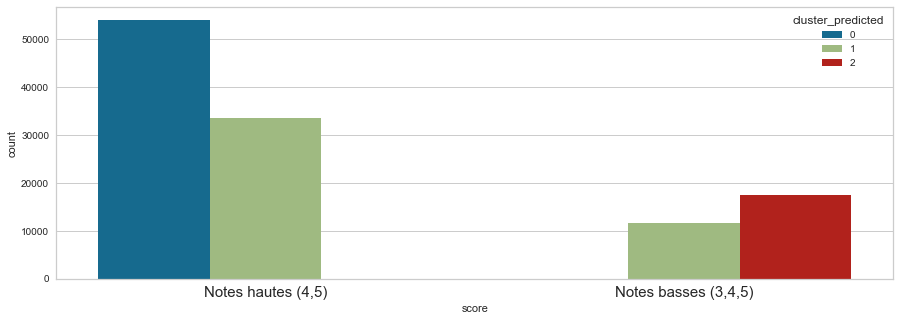

In [112]:
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['score'],order=combinedDf['score'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.xticks(fontsize=15)
plt.show()

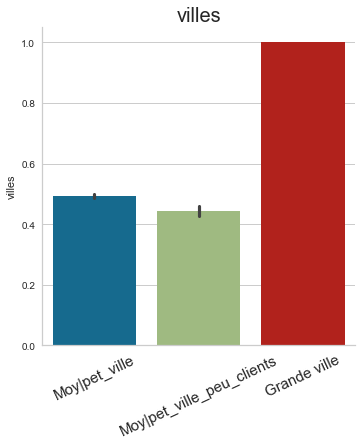

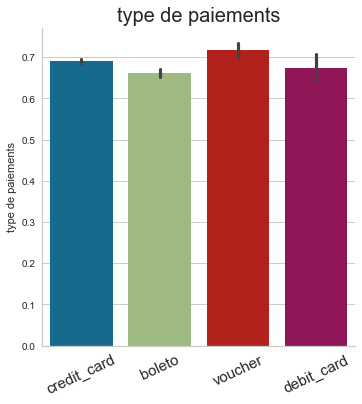

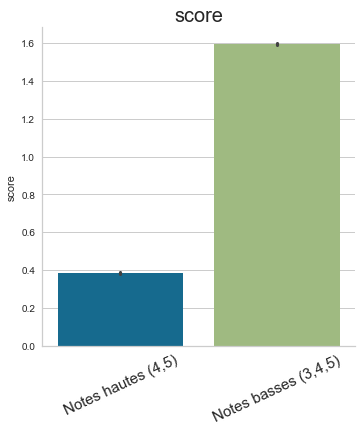

In [117]:
colonnes = [ 'villes', 'type de paiements', 'score']
for col in colonnes :
    g = sns.catplot(x=col, y='cluster_predicted', data= combinedDf, kind="bar")
    g.set_axis_labels("", col)
    plt.xticks(fontsize=15, rotation=25)
    plt.title(col, fontsize = 20)
    plt.show()